In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


In [4]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


In [5]:
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [12]:
# Select features for clustering
features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Region': lambda x: x.iloc[0]
}).reset_index()

In [13]:
# Encode region and scale features
features['RegionEncoded'] = features['Region'].astype('category').cat.codes
scaled_features = StandardScaler().fit_transform(features[['TotalValue', 'Quantity', 'RegionEncoded']])

In [14]:
os.environ["OMP_NUM_THREADS"] = "1"

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")


In [17]:
# K-Means Clustering
db_scores = []
clusters_range = range(2, 11)

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)

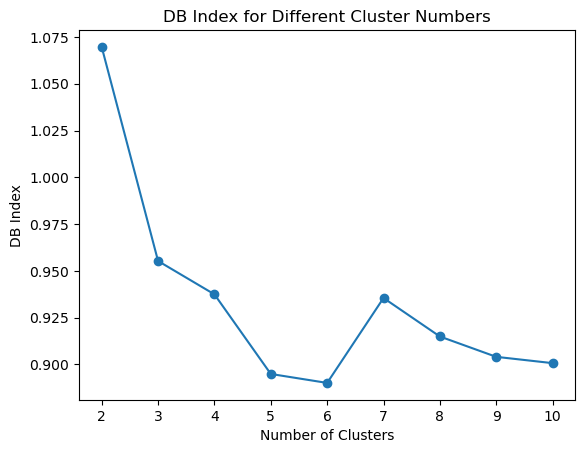

In [19]:
# Plot DB Index
plt.plot(clusters_range, db_scores, marker='o')
plt.title("DB Index for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.show()

In [20]:
# Best number of clusters
optimal_clusters = clusters_range[np.argmin(db_scores)]
print("Optimal Clusters:", optimal_clusters)

Optimal Clusters: 6


In [23]:
# Final clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)  # Explicitly set n_init
features['Cluster'] = kmeans.fit_predict(scaled_features)


In [24]:
# Save clustering results
features.to_csv("ClusteringResults.csv", index=False)